# Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from cot.models.transformer import Transformer, TransformerConfig
import seaborn as sns
from typing import List
from torch.nn.utils.rnn import pad_sequence
import random
from tqdm import trange
from copy import deepcopy

# Hyper-params

In [2]:
epochs = 10
batch_size = 64
min_len = 4
max_len = 10
total_runs = 10

config = TransformerConfig(
    vocab_size=12,
    emb_dim=128,
    n_head=1,
    seq_len=16,
    n_layer=2,
    norm="layer",
    norm_bias=True,
    weight_tying=True,
)


# Data

In [3]:
class PolyDataset(torch.utils.data.Dataset):
    def __init__(self, N=8192, seq_len=16, p=11):
        self.p = p
        self.samples = []
        for _ in range(N):
            x = torch.randint(0, p, (random.randint(2, seq_len),))
            y = (x[0] * x[1] + 1) % p
            target = torch.full((x.size(0),), p, dtype=torch.long)  # label marker
            target[-1] = y
            self.samples.append((x, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [4]:
class ParityDataset(torch.utils.data.Dataset):
    def __init__(self, N=8192, seq_len=16):
        self.samples = []
        for _ in range(N):
            length = np.random.randint(2, seq_len + 1)
            bits = np.random.randint(0, 2, size=length)
            parity = np.cumsum(bits) % 2
            self.samples.append((bits, parity))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)


In [5]:
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = pad_sequence(xs, batch_first=True, padding_value=0)
    ys = pad_sequence(ys, batch_first=True, padding_value=0)
    return xs, ys

# Model Object

In [6]:
class Trainer:
    all_accuracies = []

    def __init__(self, config, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.config = config
        self.model = Transformer(config).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.criterion = nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.task_counter = {}  
        self.accuracies = []
        self.static_index = len(Trainer.all_accuracies)   
        Trainer.all_accuracies.append([])

    def reset_optimizer(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def train(self, task='polynomial', epochs=10):
        if task == 'polynomial':
            dataset = PolyDataset()
        elif task == 'parity':
            dataset = ParityDataset()
        else:
            raise ValueError("Unknown task")

        count = self.task_counter.get(task, 0) + 1
        self.task_counter[task] = count
        task_name = f"{task} {count}"

        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn)
        accs = []

        pbar = trange(epochs)
        for epoch in pbar:
            self.model.train()
            total_loss = 0
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(x)
                loss = self.criterion(logits.view(-1, logits.size(-1)), y.view(-1))
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            acc = self.evaluate(loader, verbose=False)
            accs.append(acc)
            avg_loss = total_loss / len(loader)
            pbar.set_description(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Acc: {acc:.2%}")

        self.accuracies.append({
            "name": task_name,
            "accs": accs
        })
        
        Trainer.all_accuracies[self.static_index] = [a for entry in self.accuracies for a in entry["accs"]]

    def evaluate(self, loader, verbose=True):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                logits = self.model(x)
                preds = torch.argmax(logits, dim=-1)
                correct += (preds == y).sum().item()
                total += y.numel()
        acc = correct / total
        if verbose:
            print(f"Accuracy: {acc:.2%}")

        return acc

    def plot_accuracy(self):
        if not self.accuracies:
            print("No runs to plot.")
            return

        start_x = 0
        for entry in self.accuracies:
            name = entry["name"]
            accs = entry["accs"]
            x = list(range(start_x, start_x + len(accs)))
            plt.plot(x, accs, label=name)
            start_x += len(accs)
    
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.legend()
        plt.grid()
        plt.show()

    def fork(self):
        new_trainer = Trainer(self.config, batch_size=self.batch_size)
        new_trainer.model.load_state_dict(deepcopy(self.model.state_dict()))
        new_trainer.optimizer.load_state_dict(deepcopy(self.optimizer.state_dict()))
        new_trainer.criterion = deepcopy(self.criterion)
        new_trainer.task_counter = deepcopy(self.task_counter)
        new_trainer.accuracies = deepcopy(self.accuracies)

        Trainer.all_accuracies[new_trainer.static_index] = deepcopy(
            Trainer.all_accuracies[self.static_index]
        )

        return new_trainer


    @staticmethod
    def summarize_runs():
        # Filter out any empty lists
        valid_runs = [a for a in Trainer.all_accuracies if a]

        if not valid_runs:
            print("No valid runs to summarize.")
            return

        max_len = max(len(a) for a in valid_runs)
        padded = [a + [a[-1]] * (max_len - len(a)) for a in valid_runs]
        mean_acc = np.mean(padded, axis=0)
        std_acc = np.std(padded, axis=0)

        plt.plot(mean_acc, label="Mean Accuracy")
        plt.fill_between(range(max_len), mean_acc - std_acc, mean_acc + std_acc, alpha=0.3, label="±1 std")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Average Accuracy Over Runs")
        plt.legend()
        plt.grid(True)
        plt.show()

# Train

In [7]:
trainer = Trainer(config)
trainer.train(task='polynomial', epochs=200)

Epoch 199 | Loss: 0.0571 | Acc: 98.07%: 100%|██████████| 200/200 [06:51<00:00,  2.06s/it]


In [8]:
trainer.reset_optimizer()
trainer.train(task='parity', epochs=50)

Epoch 49 | Loss: 0.1376 | Acc: 94.07%: 100%|██████████| 50/50 [01:47<00:00,  2.14s/it]


# Evaluation

In [9]:
parity_loader = DataLoader(ParityDataset(N=8192), batch_size=64, collate_fn=collate_fn)
trainer.evaluate(parity_loader)

Accuracy: 93.83%


0.9382556790425012

# Visualize

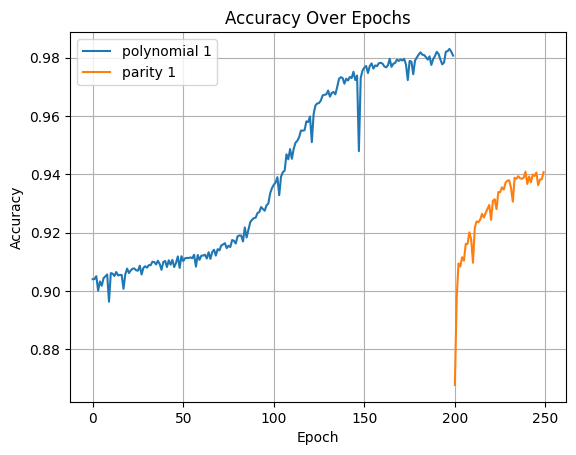

In [10]:
trainer.plot_accuracy()

# Multi-runs

Epoch 199 | Loss: 0.1439 | Acc: 94.48%: 100%|██████████| 200/200 [06:52<00:00,  2.06s/it]
Epoch 49 | Loss: 0.2847 | Acc: 84.53%: 100%|██████████| 50/50 [01:47<00:00,  2.15s/it]
Epoch 199 | Loss: 0.0668 | Acc: 97.83%: 100%|██████████| 200/200 [06:59<00:00,  2.10s/it]
Epoch 49 | Loss: 0.1525 | Acc: 93.19%: 100%|██████████| 50/50 [01:47<00:00,  2.15s/it]
Epoch 199 | Loss: 0.0716 | Acc: 97.49%: 100%|██████████| 200/200 [06:57<00:00,  2.09s/it]
Epoch 49 | Loss: 0.1341 | Acc: 93.95%: 100%|██████████| 50/50 [01:48<00:00,  2.17s/it]
Epoch 199 | Loss: 0.1106 | Acc: 96.25%: 100%|██████████| 200/200 [06:57<00:00,  2.09s/it]
Epoch 49 | Loss: 0.2139 | Acc: 90.09%: 100%|██████████| 50/50 [01:47<00:00,  2.16s/it]
Epoch 199 | Loss: 0.0610 | Acc: 97.92%: 100%|██████████| 200/200 [06:54<00:00,  2.07s/it]
Epoch 49 | Loss: 0.1349 | Acc: 94.30%: 100%|██████████| 50/50 [01:48<00:00,  2.17s/it]
Epoch 199 | Loss: 0.0621 | Acc: 97.91%: 100%|██████████| 200/200 [06:55<00:00,  2.08s/it]
Epoch 49 | Loss: 0.1447 |

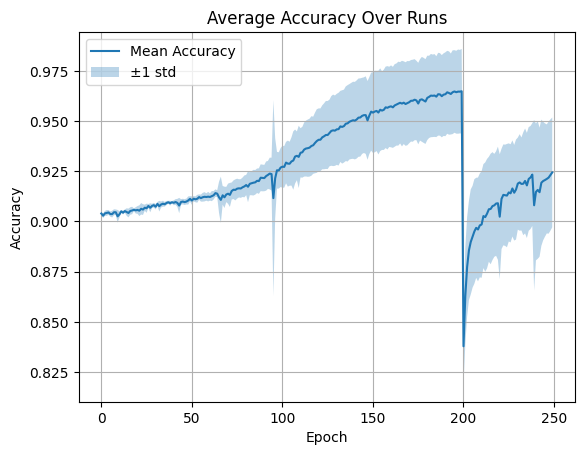

In [11]:
for _ in range(total_runs):
    trainer = Trainer(config)
    trainer.train(task='polynomial', epochs=200)
    trainer.reset_optimizer()
    trainer.train(task='parity', epochs=50)

# After several trainers
Trainer.summarize_runs()
